In [12]:
# # Full-image reconstruction pretraining with 2D U-Net on STS-2D-Tooth
#
# This notebook performs self-supervised pretraining on all 2D X-ray images
# using a simple masked-autoencoder-style objective with a 2D U-Net backbone.
# The model sees a **masked** input image and learns to reconstruct the **full** image.
#
# Pipeline:
# 1. Load the preprocessed index (`sts2d_index.csv`) and build `df_pretrain`
#    (all non-mask images, ~4000 samples).
# 2. Define a light augmentation pipeline for full-image pretraining.
# 3. Define a `FullImagePretrainDataset`:
#      - loads an image
#      - applies augmentation
#      - generates random block masks on the image
#      - returns (masked_image, target_image, mask, meta)
# 4. Define a small 2D U-Net model.
# 5. Train the U-Net to reconstruct the full image from the masked input,
#    using an L1 loss over all pixels.
#    (Optionally, you can switch to a masked-region loss to get a classic MIM objective.)
# 6. Save the pretrained U-Net weights to disk for later segmentation fine-tuning.


In [13]:
# %%
import os
from pathlib import Path
import random

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import matplotlib.pyplot as plt

# Make plots inline if you are in Jupyter
# %matplotlib inline

# -----------------------------
# Reproducibility
# -----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# -----------------------------
# Paths (aligned with data_enhance.ipynb)
# -----------------------------
DATA_ROOT = Path("./sts_tooth_data").resolve()
PROCESSED_2D_DIR = DATA_ROOT / "processed_2d"
INDEX_CSV = DATA_ROOT / "sts2d_index.csv"

print("DATA_ROOT      :", DATA_ROOT)
print("PROCESSED_2D   :", PROCESSED_2D_DIR)
print("INDEX_CSV path :", INDEX_CSV)

# -----------------------------
# Device
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

DATA_ROOT      : E:\Data\ToothSeg\sts_tooth_data
PROCESSED_2D   : E:\Data\ToothSeg\sts_tooth_data\processed_2d
INDEX_CSV path : E:\Data\ToothSeg\sts_tooth_data\sts2d_index.csv
Using device: cuda


In [14]:
# ## 2. Load index and build `df_pretrain`
#
# - We load `sts2d_index.csv` generated in `preprocessing.ipynb` / `data_enhance.ipynb`.
# - Each row corresponds to a PNG file with:
#     * rel_path
#     * age_group
#     * label_status
#     * is_mask
#     * pair_id
# - For full-image pretraining (masked-input), we only need non-mask images (`is_mask == False`).

# %%
assert INDEX_CSV.exists(), f"Index CSV not found: {INDEX_CSV}"

df = pd.read_csv(INDEX_CSV)
print("Full index shape:", df.shape)
print(df.head())

# Split into images vs masks
df_img = df[df["is_mask"] == False].copy()
df_mask = df[df["is_mask"] == True].copy()

print("\nNumber of image rows:", len(df_img))
print("Number of mask rows :", len(df_mask))

# For full-image pretraining (masked-input), we use ALL non-mask images
df_pretrain = df_img.reset_index(drop=True)
print("\nPretraining dataframe shape:", df_pretrain.shape)

print("\nValue counts — age_group:")
print(df_pretrain["age_group"].value_counts())

print("\nValue counts — label_status:")
print(df_pretrain["label_status"].value_counts())


Full index shape: (4900, 5)
                          rel_path age_group label_status  is_mask  pair_id
0  A-PXI/Labeled/Image/A_L_001.png     adult      labeled    False  a_l_001
1  A-PXI/Labeled/Image/A_L_002.png     adult      labeled    False  a_l_002
2  A-PXI/Labeled/Image/A_L_003.png     adult      labeled    False  a_l_003
3  A-PXI/Labeled/Image/A_L_004.png     adult      labeled    False  a_l_004
4  A-PXI/Labeled/Image/A_L_005.png     adult      labeled    False  a_l_005

Number of image rows: 4000
Number of mask rows : 900

Pretraining dataframe shape: (4000, 5)

Value counts — age_group:
age_group
adult       3500
children     500
Name: count, dtype: int64

Value counts — label_status:
label_status
unlabeled    3100
labeled       900
Name: count, dtype: int64


In [15]:
# ## 3. Helper functions
#

# Folder structure (from preprocessing):
#   processed_2d/
#       adult/
#         labeled/
#           images/
#           masks/
#         unlabeled/
#           images/
#       children/
#         ...
# %%
def get_image_path_from_row(row: pd.Series) -> Path:
    """
    Map a row from df_pretrain to a local image path in processed_2d.

    We ignore the original `rel_path` subfolder structure and use:
        processed_2d / age_group / label_status / images / <filename>

    For example:
      rel_path = "A-PXI/Labeled/Image/A_L_001.png"
      age_group = "adult"
      label_status = "labeled"

    -> processed_2d/adult/labeled/images/A_L_001.png
    """
    rel = Path(row["rel_path"])
    age_group = row["age_group"]
    label_status = row["label_status"]

    # Handle potential "unknown" but in df_pretrain it should be adult/children + labeled/unlabeled
    if age_group not in ("adult", "children"):
        age_group = "unknown"
    if label_status not in ("labeled", "unlabeled"):
        label_status = "unknown"

    img_path = PROCESSED_2D_DIR / age_group / label_status / "images" / rel.name
    return img_path


def load_image_as_array(path: Path) -> np.ndarray:
    """
    Load a PNG as a grayscale numpy array of shape (H, W), dtype uint8.

    We do NOT normalize or resize here. That will be handled by Albumentations.
    """
    if not path.exists():
        raise FileNotFoundError(f"Image file not found: {path}")
    img = Image.open(path).convert("L")  # "L" = single-channel grayscale
    return np.array(img)


# Quick sanity check: try loading one random image
sample_row = df_pretrain.sample(1, random_state=SEED).iloc[0]
sample_path = get_image_path_from_row(sample_row)
sample_img = load_image_as_array(sample_path)
print("Sample image path:", sample_path)
print("Sample image shape:", sample_img.shape)


Sample image path: E:\Data\ToothSeg\sts_tooth_data\processed_2d\adult\labeled\images\A_L_556.png
Sample image shape: (320, 640)


In [16]:
# ## 4. Light augmentation for full-image pretraining (masked-input)
#
# We define a mild augmentation pipeline:
# - Resize to a fixed size (320 x 640)
# - Random horizontal flip
# - Small rotation (to simulate slightly different acquisition angles)
# - Mild brightness/contrast jitter
# - Mild Gaussian noise and blur
# - Normalize to mean=0.5, std=0.25 and convert to PyTorch tensor
#
# Important:
# - We do *not* perform aggressive cropping or cutout here.
# - Masking (MIM) will be handled separately by our Dataset.
# %%
TARGET_HEIGHT = 320
TARGET_WIDTH = 640

def build_fullimage_pretrain_transform() -> A.Compose:
    return A.Compose(
        [
            A.Resize(height=TARGET_HEIGHT, width=TARGET_WIDTH),
            A.HorizontalFlip(p=0.5),
            A.Rotate(
                limit=5,
                border_mode=cv2.BORDER_REFLECT_101,
                p=0.5,
            ),
            # A.RandomBrightnessContrast(
            #     brightness_limit=0.1,
            #     contrast_limit=0.1,
            #     p=0.5,
            # ),
            # A.GaussNoise(p=0.1),
            # A.GaussianBlur(blur_limit=(3, 5), p=0.2),
            # A.ToFloat(max_value=255.0),
            A.Normalize(mean=(0.5,), std=(0.25,)),
            ToTensorV2(),
        ]
    )

pretrain_transform = build_fullimage_pretrain_transform()
print("Full-image pretrain transform created.")

Full-image pretrain transform created.


In [17]:
# ## 5. Random block mask generator
#
# For masked-input (MIM-style) pretraining with a 2D U-Net, we will:
# - Work in pixel space (H, W), not in token space.
# - Generate random block masks on the *image plane*:
#     * Each mask is a rectangle with random size and position.
#     * The union of all rectangles forms the final mask.
# - The model will see the masked image and try to reconstruct the original.
#
# The function below creates a binary mask of shape (H, W) where:
#   mask[y, x] = 1.0 means "this pixel is masked (to be reconstructed)".
# %%

def random_block_mask(
    height: int,
    width: int,
    num_blocks: int = 8,
    # Theoretical minimum total area: 8 × 4.0% = 32.0% Theoretical maximum total area: 8 × 9.0% = 72.0%
    min_block_fraction: float = 0.2,
    max_block_fraction: float = 0.3,
) -> np.ndarray:
    """
    Generate a random block mask (H, W) in {0.0, 1.0},
    where 1.0 = masked pixel.
    """
    mask = np.zeros((height, width), dtype=np.float32)

    for _ in range(num_blocks):
        block_h = int(np.random.uniform(min_block_fraction, max_block_fraction) * height)
        block_w = int(np.random.uniform(min_block_fraction, max_block_fraction) * width)

        block_h = max(1, min(block_h, height))
        block_w = max(1, min(block_w, width))

        y1 = np.random.randint(0, max(1, height - block_h + 1))
        x1 = np.random.randint(0, max(1, width - block_w + 1))

        y2 = min(height, y1 + block_h)
        x2 = min(width, x1 + block_w)

        mask[y1:y2, x1:x2] = 1.0

    return mask


In [18]:
# %% [markdown]
# ## 6. `FullImagePretrainDataset`
#
# For each image row in `df_pretrain`, this Dataset will:
#
# 1. Load the raw X-ray image (grayscale).
# 2. Apply the full-image pretrain transform (resize + mild augment + normalize + ToTensor).
#    - `image` is a FloatTensor of shape (1, H, W).
# 3. Generate a random block mask in pixel coordinates:
#    - `mask_np`: (H, W), float32 in {0, 1}
# 4. Construct:
#    - `target_img`  = the full augmented image (ground truth for reconstruction)
#    - `masked_img`  = `target_img * (1 - mask)`  (we simply zero out masked pixels)
#    - `mask_tensor` = mask as FloatTensor with shape (1, H, W)
# 5. Return:
#    - masked_img  (masked input to the model)
#    - target_img  (target for reconstruction)
#    - mask_tensor (which pixels to focus the loss on)
#    - meta        (some metadata: path, age_group, label_status, etc.)

class FullImagePretrainDataset(Dataset):
    def __init__(
        self,
        df_pretrain: pd.DataFrame,
        transform: A.Compose,
        num_blocks: int = 8,
        min_block_fraction: float = 0.2,
        max_block_fraction: float = 0.3,
    ):
        self.df = df_pretrain.reset_index(drop=True)
        self.transform = transform
        self.num_blocks = num_blocks
        self.min_block_fraction = min_block_fraction
        self.max_block_fraction = max_block_fraction

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]

        img_path = get_image_path_from_row(row)
        img_np = load_image_as_array(img_path)  # (H, W) uint8

        # 1) augment + normalize
        transformed = self.transform(image=img_np)
        img_tensor = transformed["image"]  # (1, H, W), float32

        # 2) block mask in pixel space
        _, H, W = img_tensor.shape
        mask_np = random_block_mask(
            height=H,
            width=W,
            num_blocks=self.num_blocks,
            min_block_fraction=self.min_block_fraction,
            max_block_fraction=self.max_block_fraction,
        )
        mask_tensor = torch.from_numpy(mask_np).unsqueeze(0)  # (1, H, W)

        # 3) construct masked input & target
        target_img = img_tensor                      # full augmented image
        masked_img = target_img * (1.0 - mask_tensor)  # zero out masked pixels

        meta = {
            "img_path": str(img_path),
            "pair_id": row["pair_id"],
            "age_group": row["age_group"],
            "label_status": row["label_status"],
        }

        return masked_img, target_img, mask_tensor, meta


Number of pretrain samples: 4000

=== Sample 0 ===
Image path : E:\Data\ToothSeg\sts_tooth_data\processed_2d\adult\labeled\images\A_L_001.png
age_group  : adult
label_status: labeled
range target : -2.0 -> 2.0
range masked : -2.0 -> 2.0
range mask   : 0.0 -> 1.0


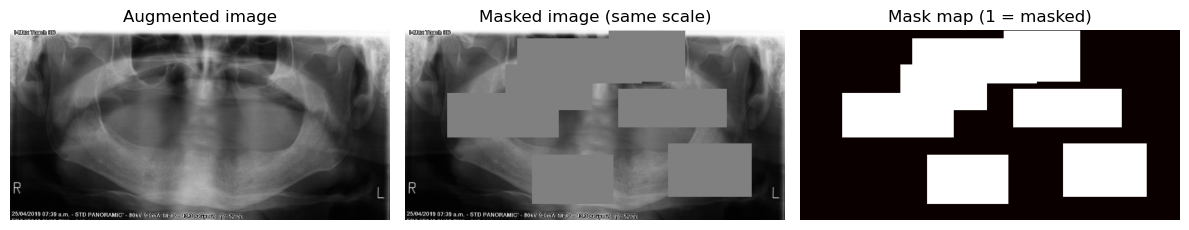


=== Sample 1 ===
Image path : E:\Data\ToothSeg\sts_tooth_data\processed_2d\adult\labeled\images\A_L_002.png
age_group  : adult
label_status: labeled
range target : -2.0 -> 2.0
range masked : -2.0 -> 2.0
range mask   : 0.0 -> 1.0


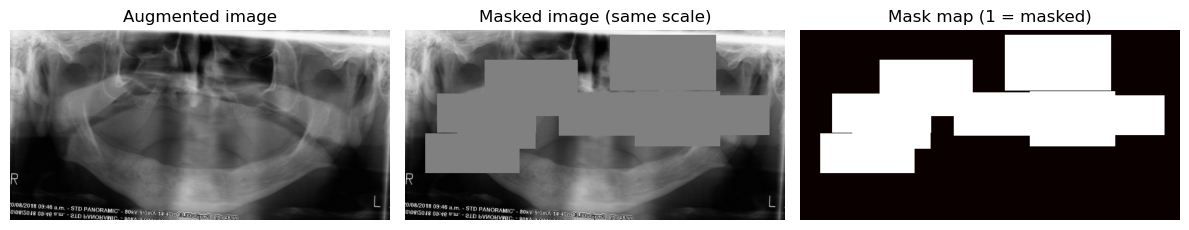


=== Sample 2 ===
Image path : E:\Data\ToothSeg\sts_tooth_data\processed_2d\adult\labeled\images\A_L_003.png
age_group  : adult
label_status: labeled
range target : -1.7960785627365112 -> 2.0
range masked : -1.7960785627365112 -> 2.0
range mask   : 0.0 -> 1.0


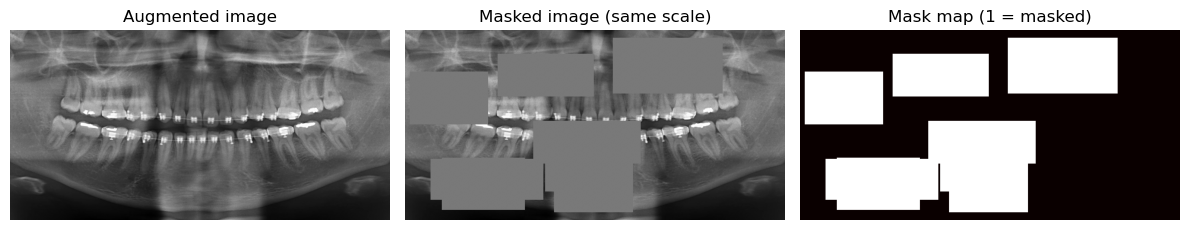

In [19]:
# ## 7. Sanity check: visualize masked input and targets
#
# We sample a few images from the dataset and visualize:
# - Original augmented image
# - Masked image (same intensity scale as target)
# - Mask map
# %%
pretrain_dataset = FullImagePretrainDataset(
    df_pretrain=df_pretrain,
    transform=pretrain_transform,
    num_blocks=8,
    min_block_fraction=0.2,
    max_block_fraction=0.3,
)

print("Number of pretrain samples:", len(pretrain_dataset))

# Visualize a few samples
NUM_VIS_SAMPLES = 3

for i in range(NUM_VIS_SAMPLES):
    masked_img, target_img, mask_tensor, meta = pretrain_dataset[i]

    # Convert to numpy for visualization
    # target_img: (1, H, W)
    target_np = target_img.squeeze(0).cpu().numpy()
    masked_np = masked_img.squeeze(0).cpu().numpy()
    mask_np   = mask_tensor.squeeze(0).cpu().numpy()

    print("\n=== Sample", i, "===")
    print("Image path :", meta["img_path"])
    print("age_group  :", meta["age_group"])
    print("label_status:", meta["label_status"])
    print("range target :", float(target_np.min()), "->", float(target_np.max()))
    print("range masked :", float(masked_np.min()), "->", float(masked_np.max()))
    print("range mask   :", float(mask_np.min()),   "->", float(mask_np.max()))

    # Use the same intensity range for target and masked image
    vmin, vmax = target_np.min(), target_np.max()

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(target_np, cmap="gray")
    axes[0].set_title("Augmented image")
    axes[0].axis("off")

    axes[1].imshow(masked_np, cmap="gray", vmin=vmin, vmax=vmax)
    axes[1].set_title("Masked image (same scale)")
    axes[1].axis("off")

    axes[2].imshow(mask_np, cmap="hot", vmin=0, vmax=1)
    axes[2].set_title("Mask map (1 = masked)")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()


In [20]:
# ## 8. 2D U-Net model definition
#
# We implement a standard 2D U-Net:
# - Encoder: four levels with downsampling by factor 2 at each level.
# - Decoder: four upsampling levels with skip connections.
# - Input:  1-channel grayscale image (1, 320, 640).
# - Output: 1-channel reconstruction (1, 320, 640).
#
# This model will be pretrained with a masked reconstruction objective
# and later reused as a backbone for tooth segmentation.

# %%
class DoubleConv(nn.Module):
    """(Conv2d -> BN -> ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if mid_channels is None:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with MaxPool then DoubleConv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            DoubleConv(in_channels, out_channels),
        )

    def forward(self, x):
        return self.block(x)


class Up(nn.Module):
    """Upscaling then DoubleConv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if use bilinear upsampling, reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # x1: from previous decoder level
        # x2: from encoder skip connection
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        # pad x1 to have the same size as x2 if needed
        x1 = nn.functional.pad(
            x1,
            [diffX // 2, diffX - diffX // 2,
             diffY // 2, diffY - diffY // 2],
        )

        # concatenate along channels
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    """Final 1x1 convolution to produce output channels"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet2D(nn.Module):
    """
    2D U-Net backbone for MIM pretraining.

    - in_channels:  1 (grayscale)
    - out_channels: 1 (reconstructed grayscale)
    """

    def __init__(self, in_channels=1, out_channels=1, base_channels=32, bilinear=True):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.bilinear = bilinear

        self.inc = DoubleConv(in_channels, base_channels)
        self.down1 = Down(base_channels, base_channels * 2)
        self.down2 = Down(base_channels * 2, base_channels * 4)
        self.down3 = Down(base_channels * 4, base_channels * 8)
        self.down4 = Down(base_channels * 8, base_channels * 8)

        self.up1 = Up(base_channels * 16, base_channels * 4, bilinear)
        self.up2 = Up(base_channels * 8, base_channels * 2, bilinear)
        self.up3 = Up(base_channels * 4, base_channels, bilinear)
        self.up4 = Up(base_channels * 2, base_channels, bilinear)

        self.outc = OutConv(base_channels, out_channels)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)      # (B, C, H, W)
        x2 = self.down1(x1)   # (B, 2C, H/2, W/2)
        x3 = self.down2(x2)   # (B, 4C, H/4, W/4)
        x4 = self.down3(x3)   # (B, 8C, H/8, W/8)
        x5 = self.down4(x4)   # (B, 8C, H/16, W/16)

        # Decoder with skip connections
        x = self.up1(x5, x4)  # (B, 4C, H/8,  W/8)
        x = self.up2(x,  x3)  # (B, 2C, H/4,  W/4)
        x = self.up3(x,  x2)  # (B, C,  H/2,  W/2)
        x = self.up4(x,  x1)  # (B, C,  H,    W)

        logits = self.outc(x) # (B, out_channels, H, W)
        return logits


# Instantiate model
model = UNet2D(in_channels=1, out_channels=1, base_channels=32, bilinear=True)
model = model.to(device)
print(model)



UNet2D(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (block): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          

In [21]:
# # ## 9. DataLoader and reconstruction losses
# #
# # - We build a DataLoader on top of `FullImagePretrainDataset`.
# # - Loss functions:
# #     - `masked_region_l1_loss`: L1 over masked pixels only (classic MIM-style) ----> not using now
# #     - `full_image_l1_loss`: L1 over all pixels (used in the loop below)
# #
# # This is one simple version of masked-input (MIM-style) training. You can later
# # experiment with other losses (L2, SSIM, perceptual loss, etc.).
#
BATCH_SIZE = 4
NUM_WORKERS = 0  # adjust depending on your machine

pretrain_dataset = FullImagePretrainDataset(
    df_pretrain=df_pretrain,
    transform=pretrain_transform,
    num_blocks=8,
    min_block_fraction=0.2,
    max_block_fraction=0.3,
)

pretrain_loader = DataLoader(
    pretrain_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=(device.type == "cuda"),
)

print("Pretrain DataLoader is ready. Batches:", len(pretrain_loader))


def masked_region_l1_loss(pred: torch.Tensor, target: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    """
    Compute L1 loss on masked pixels only.

    Args:
        pred:   (B, 1, H, W)
        target: (B, 1, H, W)
        mask:   (B, 1, H, W) in {0,1}, where 1 = masked pixel

    Returns:
        scalar loss
    """
    # element-wise L1
    l1 = torch.abs(pred - target)  # (B, 1, H, W)

    # focus only on masked positions
    masked_l1 = l1 * mask

    # avoid division by zero if mask is empty
    denom = mask.sum()
    if denom.item() < 1.0:
        # fallback: full-image loss
        return l1.mean()

    loss = masked_l1.sum() / denom
    return loss

#Loss functions for pretraining

import torch
import torch.nn.functional as F

def masked_region_l1_loss(pred, target, mask, eps: float = 1e-6):
    """
    Original masked-region reconstruction loss (only on masked regions).
    pred, target, mask: (B, 1, H, W)
    mask == 1 means "this pixel is masked and should be reconstructed".
    """
    diff = torch.abs(pred - target) * mask  # keep error only where mask = 1
    # average over masked pixels; avoid division by zero
    denom = mask.sum() + eps
    return diff.sum() / denom


def full_image_l1_loss(pred, target):
    """
    Full-image reconstruction loss (what you want now).
    pred, target: (B, 1, H, W)
    L1 averaged over ALL pixels, no mask involved.
    """
    return F.l1_loss(pred, target, reduction="mean")



Pretrain DataLoader is ready. Batches: 1000


In [22]:
# ## 10. Training hyperparameters and optimizer
#
# - Optimizer: Adam
# - Learning rate: 1e-3 (you can tune this)
# - Epochs: start small (e.g. 20) for a first run
#
# You can later increase the number of epochs if loss keeps decreasing.
# %%
LR = 5e-5
NUM_EPOCHS = 50  # adjust based on your GPU / patience

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
print("Optimizer:", optimizer)

from torch.utils.tensorboard import SummaryWriter

# TensorBoard log directory
LOG_DIR = DATA_ROOT / "runs" / "fullimage_unet"
LOG_DIR.mkdir(parents=True, exist_ok=True)

writer = SummaryWriter(log_dir=str(LOG_DIR))
print("TensorBoard log dir:", LOG_DIR)

# This will be used to index batch-wise logs
global_step = 0

Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 5e-05
    maximize: False
    weight_decay: 0
)
TensorBoard log dir: E:\Data\ToothSeg\sts_tooth_data\runs\fullimage_unet


In [23]:
# %% 11. Full-image pretraining loop with tqdm
# from tqdm.auto import tqdm
# 
# model.train()
# 
# for epoch in range(1, NUM_EPOCHS + 1):
#     running_loss = 0.0
#     num_batches = 0
# 
#     # By wrapping a dataloader in tqdm, you can see the progress and current loss of each batch.
#     pbar = tqdm(pretrain_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS}", leave=True)
# 
#     for batch in pbar:
#         masked_img, target_img, mask_tensor, meta = batch
#         # masked_img, target_img, mask_tensor: (B, 1, H, W)
# 
#         masked_img = masked_img.to(device)
#         target_img = target_img.to(device)
#         mask_tensor = mask_tensor.to(device)
# 
#         optimizer.zero_grad()
# 
#         # Forward
#         pred = model(masked_img)  # (B, 1, H, W)
# 
#         # Loss on masked pixels
#         loss = masked_region_l1_loss(pred, target_img, mask_tensor)
#         # Backward
#         loss.backward()
#         optimizer.step()
#         
#         running_loss += loss.item()
#         num_batches += 1
#         
#         writer.add_scalar("train/batch_loss", loss.item(), global_step)
#         global_step += 1
#         
#         # The progress bar displays the current batch loss.
#         pbar.set_postfix({"batch_loss": loss.item()})
# 
#     avg_loss = running_loss / max(1, num_batches)
#     print(f"Epoch [{epoch:02d}/{NUM_EPOCHS}] - Avg masked-region reconstruction loss: {avg_loss:.6f}")
#     writer.add_scalar('Loss/Train', avg_loss, epoch)
#     
# # save the weights
# SAVE_DIR = DATA_ROOT / "checkpoints"
# SAVE_DIR.mkdir(parents=True, exist_ok=True)
# 
# save_path = SAVE_DIR / "unet2d_mim_pretrained.pth"
# torch.save(model.state_dict(), save_path)
# 
# print("Pretrained U-Net weights saved to:", save_path)


# %% 11. full-image reconstruction Pretraining loop with tqdm
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter

# ====== TensorBoard writer (skip this section if writer has been created before) ======
LOG_DIR = DATA_ROOT / "runs" / "fullimage_unet_fullimg"
LOG_DIR.mkdir(parents=True, exist_ok=True)
writer = SummaryWriter(log_dir=str(LOG_DIR))
print("TensorBoard log dir:", LOG_DIR)

global_step = 0  # batch-level step counter

# ====== Ensure model and optimizer are ready ======
model.to(device)
model.train()

# If optimizer exists, reuse it; otherwise, define one:
# LR = 1e-3
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)

for epoch in range(1, NUM_EPOCHS + 1):
    running_loss = 0.0
    num_batches = 0

    # wrap dataloader with tqdm to see progress and loss for each batch
    pbar = tqdm(pretrain_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS}", leave=True)

    for batch in pbar:
        masked_img, target_img, mask_tensor, meta = batch
        # masked_img, target_img, mask_tensor: (B, 1, H, W)

        masked_img = masked_img.to(device)
        target_img = target_img.to(device)
        mask_tensor = mask_tensor.to(device)  # mask is only kept for visualization now, not used in loss

        optimizer.zero_grad()

        # Forward
        pred = model(masked_img)  # (B, 1, H, W)

        # 🔑 Full-image reconstruction loss: Use L1 on the entire target image, not just the masked region
        loss = full_image_l1_loss(pred, target_img)

        # Backward
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        num_batches += 1

        # TensorBoard: log loss for each batch
        writer.add_scalar("train/batch_loss", loss.item(), global_step)
        global_step += 1
        
        # Display current batch loss on the progress bar
        pbar.set_postfix({"batch_loss": f"{loss.item():.6f}"})

    avg_loss = running_loss / max(1, num_batches)
    print(f"Epoch [{epoch:02d}/{NUM_EPOCHS}] - Avg full-image L1 loss: {avg_loss:.6f}")
    writer.add_scalar("train/epoch_loss", avg_loss, epoch)

# Training finished, save weights
SAVE_DIR = DATA_ROOT / "checkpoints"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

save_path = SAVE_DIR / "unet2d_fullimage_pretrained.pth"
torch.save(model.state_dict(), save_path)

print("Full-image pretrained U-Net weights saved to:", save_path)

writer.close()


TensorBoard log dir: E:\Data\ToothSeg\sts_tooth_data\runs\fullimage_unet_fullimg


Epoch 1/50: 100%|██████████| 1000/1000 [02:57<00:00,  5.62it/s, batch_loss=0.164505]


Epoch [01/50] - Avg full-image L1 loss: 0.197896


Epoch 2/50: 100%|██████████| 1000/1000 [03:00<00:00,  5.55it/s, batch_loss=0.168851]


Epoch [02/50] - Avg full-image L1 loss: 0.165049


Epoch 3/50: 100%|██████████| 1000/1000 [03:43<00:00,  4.48it/s, batch_loss=0.131240]


Epoch [03/50] - Avg full-image L1 loss: 0.155330


Epoch 4/50: 100%|██████████| 1000/1000 [04:14<00:00,  3.93it/s, batch_loss=0.238406]


Epoch [04/50] - Avg full-image L1 loss: 0.147001


Epoch 5/50: 100%|██████████| 1000/1000 [04:13<00:00,  3.95it/s, batch_loss=0.123945]


Epoch [05/50] - Avg full-image L1 loss: 0.142116


Epoch 6/50: 100%|██████████| 1000/1000 [03:09<00:00,  5.28it/s, batch_loss=0.108942]


Epoch [06/50] - Avg full-image L1 loss: 0.139354


Epoch 7/50: 100%|██████████| 1000/1000 [03:03<00:00,  5.46it/s, batch_loss=0.102434]


Epoch [07/50] - Avg full-image L1 loss: 0.135008


Epoch 8/50: 100%|██████████| 1000/1000 [03:02<00:00,  5.48it/s, batch_loss=0.135716]


Epoch [08/50] - Avg full-image L1 loss: 0.132622


Epoch 9/50: 100%|██████████| 1000/1000 [03:11<00:00,  5.23it/s, batch_loss=0.112143]


Epoch [09/50] - Avg full-image L1 loss: 0.131121


Epoch 10/50: 100%|██████████| 1000/1000 [03:06<00:00,  5.36it/s, batch_loss=0.128875]


Epoch [10/50] - Avg full-image L1 loss: 0.128762


Epoch 11/50: 100%|██████████| 1000/1000 [03:04<00:00,  5.41it/s, batch_loss=0.127163]


Epoch [11/50] - Avg full-image L1 loss: 0.126213


Epoch 12/50: 100%|██████████| 1000/1000 [03:08<00:00,  5.30it/s, batch_loss=0.151919]


Epoch [12/50] - Avg full-image L1 loss: 0.125159


Epoch 13/50: 100%|██████████| 1000/1000 [03:08<00:00,  5.29it/s, batch_loss=0.131838]


Epoch [13/50] - Avg full-image L1 loss: 0.123786


Epoch 14/50: 100%|██████████| 1000/1000 [03:13<00:00,  5.18it/s, batch_loss=0.131816]


Epoch [14/50] - Avg full-image L1 loss: 0.122878


Epoch 15/50: 100%|██████████| 1000/1000 [03:15<00:00,  5.13it/s, batch_loss=0.098060]


Epoch [15/50] - Avg full-image L1 loss: 0.121549


Epoch 16/50: 100%|██████████| 1000/1000 [03:14<00:00,  5.14it/s, batch_loss=0.118073]


Epoch [16/50] - Avg full-image L1 loss: 0.120626


Epoch 17/50: 100%|██████████| 1000/1000 [03:15<00:00,  5.12it/s, batch_loss=0.096063]


Epoch [17/50] - Avg full-image L1 loss: 0.119022


Epoch 18/50: 100%|██████████| 1000/1000 [03:16<00:00,  5.10it/s, batch_loss=0.138860]


Epoch [18/50] - Avg full-image L1 loss: 0.119356


Epoch 19/50: 100%|██████████| 1000/1000 [03:12<00:00,  5.18it/s, batch_loss=0.155635]


Epoch [19/50] - Avg full-image L1 loss: 0.118262


Epoch 20/50: 100%|██████████| 1000/1000 [03:08<00:00,  5.31it/s, batch_loss=0.102087]


Epoch [20/50] - Avg full-image L1 loss: 0.116678


Epoch 21/50: 100%|██████████| 1000/1000 [03:11<00:00,  5.23it/s, batch_loss=0.119729]


Epoch [21/50] - Avg full-image L1 loss: 0.115880


Epoch 22/50: 100%|██████████| 1000/1000 [03:04<00:00,  5.41it/s, batch_loss=0.108076]


Epoch [22/50] - Avg full-image L1 loss: 0.116131


Epoch 23/50: 100%|██████████| 1000/1000 [03:01<00:00,  5.49it/s, batch_loss=0.097865]


Epoch [23/50] - Avg full-image L1 loss: 0.114530


Epoch 24/50: 100%|██████████| 1000/1000 [03:01<00:00,  5.50it/s, batch_loss=0.105380]


Epoch [24/50] - Avg full-image L1 loss: 0.113803


Epoch 25/50: 100%|██████████| 1000/1000 [03:01<00:00,  5.50it/s, batch_loss=0.092787]


Epoch [25/50] - Avg full-image L1 loss: 0.113403


Epoch 26/50: 100%|██████████| 1000/1000 [03:02<00:00,  5.49it/s, batch_loss=0.109317]


Epoch [26/50] - Avg full-image L1 loss: 0.112771


Epoch 27/50: 100%|██████████| 1000/1000 [03:01<00:00,  5.50it/s, batch_loss=0.088483]


Epoch [27/50] - Avg full-image L1 loss: 0.111757


Epoch 28/50: 100%|██████████| 1000/1000 [03:03<00:00,  5.44it/s, batch_loss=0.107661]


Epoch [28/50] - Avg full-image L1 loss: 0.111788


Epoch 29/50: 100%|██████████| 1000/1000 [03:04<00:00,  5.41it/s, batch_loss=0.119487]


Epoch [29/50] - Avg full-image L1 loss: 0.111721


Epoch 30/50: 100%|██████████| 1000/1000 [03:06<00:00,  5.36it/s, batch_loss=0.103016]


Epoch [30/50] - Avg full-image L1 loss: 0.111765


Epoch 31/50: 100%|██████████| 1000/1000 [03:06<00:00,  5.37it/s, batch_loss=0.112190]


Epoch [31/50] - Avg full-image L1 loss: 0.110486


Epoch 32/50: 100%|██████████| 1000/1000 [03:05<00:00,  5.38it/s, batch_loss=0.103126]


Epoch [32/50] - Avg full-image L1 loss: 0.110585


Epoch 33/50: 100%|██████████| 1000/1000 [03:06<00:00,  5.38it/s, batch_loss=0.106491]


Epoch [33/50] - Avg full-image L1 loss: 0.110387


Epoch 34/50: 100%|██████████| 1000/1000 [03:01<00:00,  5.50it/s, batch_loss=0.108755]


Epoch [34/50] - Avg full-image L1 loss: 0.108703


Epoch 35/50: 100%|██████████| 1000/1000 [02:58<00:00,  5.59it/s, batch_loss=0.119212]


Epoch [35/50] - Avg full-image L1 loss: 0.108489


Epoch 36/50: 100%|██████████| 1000/1000 [02:59<00:00,  5.58it/s, batch_loss=0.115728]


Epoch [36/50] - Avg full-image L1 loss: 0.108450


Epoch 37/50: 100%|██████████| 1000/1000 [03:03<00:00,  5.44it/s, batch_loss=0.130306]


Epoch [37/50] - Avg full-image L1 loss: 0.107935


Epoch 38/50: 100%|██████████| 1000/1000 [03:02<00:00,  5.47it/s, batch_loss=0.097304]


Epoch [38/50] - Avg full-image L1 loss: 0.108207


Epoch 39/50: 100%|██████████| 1000/1000 [03:00<00:00,  5.54it/s, batch_loss=0.093953]


Epoch [39/50] - Avg full-image L1 loss: 0.108400


Epoch 40/50: 100%|██████████| 1000/1000 [02:59<00:00,  5.58it/s, batch_loss=0.111334]


Epoch [40/50] - Avg full-image L1 loss: 0.106860


Epoch 41/50: 100%|██████████| 1000/1000 [03:03<00:00,  5.46it/s, batch_loss=0.088854]


Epoch [41/50] - Avg full-image L1 loss: 0.107157


Epoch 42/50: 100%|██████████| 1000/1000 [03:08<00:00,  5.30it/s, batch_loss=0.115696]


Epoch [42/50] - Avg full-image L1 loss: 0.107007


Epoch 43/50: 100%|██████████| 1000/1000 [03:01<00:00,  5.50it/s, batch_loss=0.093493]


Epoch [43/50] - Avg full-image L1 loss: 0.106199


Epoch 44/50: 100%|██████████| 1000/1000 [02:56<00:00,  5.65it/s, batch_loss=0.089137]


Epoch [44/50] - Avg full-image L1 loss: 0.106223


Epoch 45/50: 100%|██████████| 1000/1000 [02:57<00:00,  5.65it/s, batch_loss=0.089374]


Epoch [45/50] - Avg full-image L1 loss: 0.106308


Epoch 46/50: 100%|██████████| 1000/1000 [02:56<00:00,  5.66it/s, batch_loss=0.095819]


Epoch [46/50] - Avg full-image L1 loss: 0.105700


Epoch 47/50: 100%|██████████| 1000/1000 [02:58<00:00,  5.61it/s, batch_loss=0.110118]


Epoch [47/50] - Avg full-image L1 loss: 0.106874


Epoch 48/50: 100%|██████████| 1000/1000 [02:56<00:00,  5.66it/s, batch_loss=0.120620]


Epoch [48/50] - Avg full-image L1 loss: 0.105149


Epoch 49/50: 100%|██████████| 1000/1000 [02:56<00:00,  5.67it/s, batch_loss=0.109422]


Epoch [49/50] - Avg full-image L1 loss: 0.105059


Epoch 50/50: 100%|██████████| 1000/1000 [02:56<00:00,  5.67it/s, batch_loss=0.136800]

Epoch [50/50] - Avg full-image L1 loss: 0.104379
Full-image pretrained U-Net weights saved to: E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_fullimage_pretrained.pth


In [24]:
model = UNet2D(in_channels=1, out_channels=1, base_channels=32, bilinear=True)
model = model.to(device)

ckpt_path = DATA_ROOT / "checkpoints" / "unet2d_fullimage_pretrained.pth"
state_dict = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state_dict)
print("Loaded pretrained weights from:", ckpt_path)

Loaded pretrained weights from: E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_fullimage_pretrained.pth



=== Reconstruction preview sample 0 ===
Image path : E:\Data\ToothSeg\sts_tooth_data\processed_2d\adult\labeled\images\A_L_001.png
age_group  : adult
label_status: labeled
target_np min/max : -1.9843138456344604 1.9843138456344604
masked_np min/max : -1.9843138456344604 1.9843138456344604
mask_np   min/max : 0.0 1.0
pred_img  min/max : -2.2410409450531006 2.291898250579834


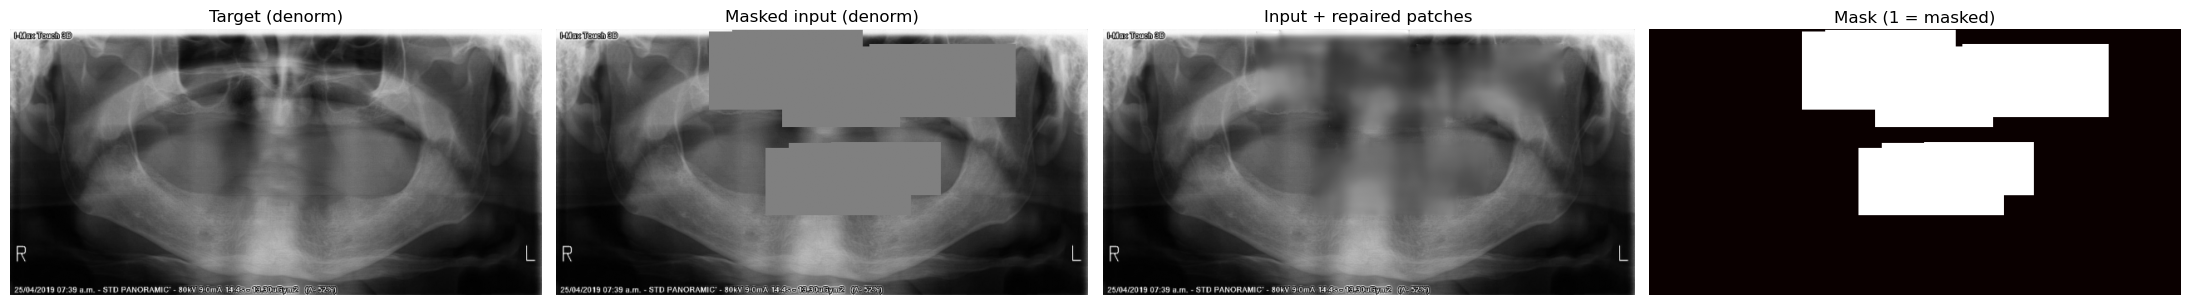


=== Reconstruction preview sample 1 ===
Image path : E:\Data\ToothSeg\sts_tooth_data\processed_2d\adult\labeled\images\A_L_002.png
age_group  : adult
label_status: labeled
target_np min/max : -2.0 2.0
masked_np min/max : -1.9843138456344604 2.0
mask_np   min/max : 0.0 1.0
pred_img  min/max : -2.2280433177948 2.2460148334503174


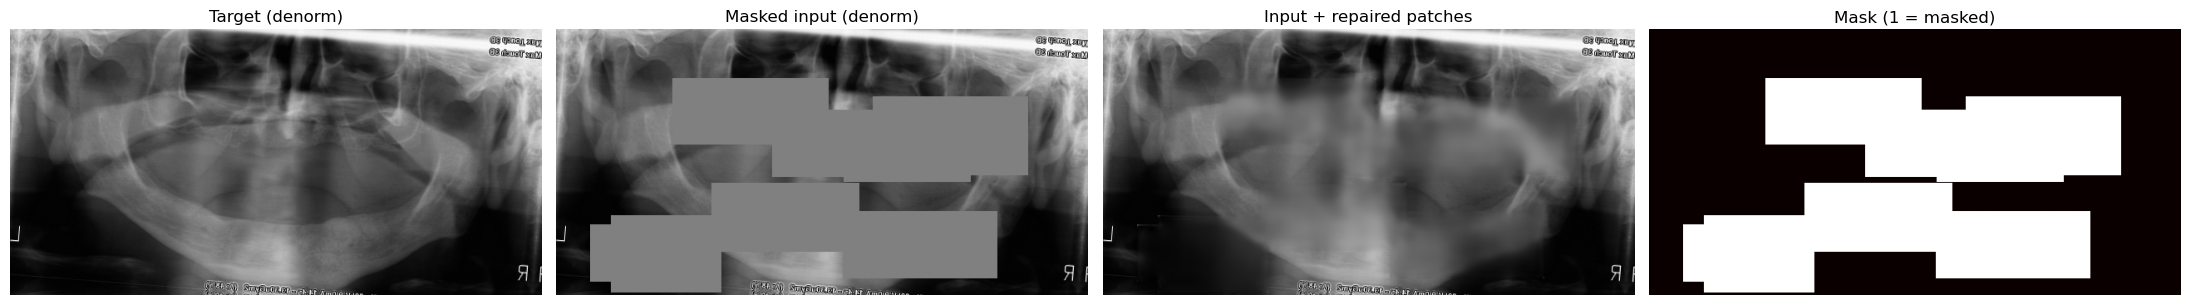


=== Reconstruction preview sample 2 ===
Image path : E:\Data\ToothSeg\sts_tooth_data\processed_2d\adult\labeled\images\A_L_003.png
age_group  : adult
label_status: labeled
target_np min/max : -1.7960785627365112 2.0
masked_np min/max : -1.7960785627365112 2.0
mask_np   min/max : 0.0 1.0
pred_img  min/max : -1.764676809310913 2.043959617614746


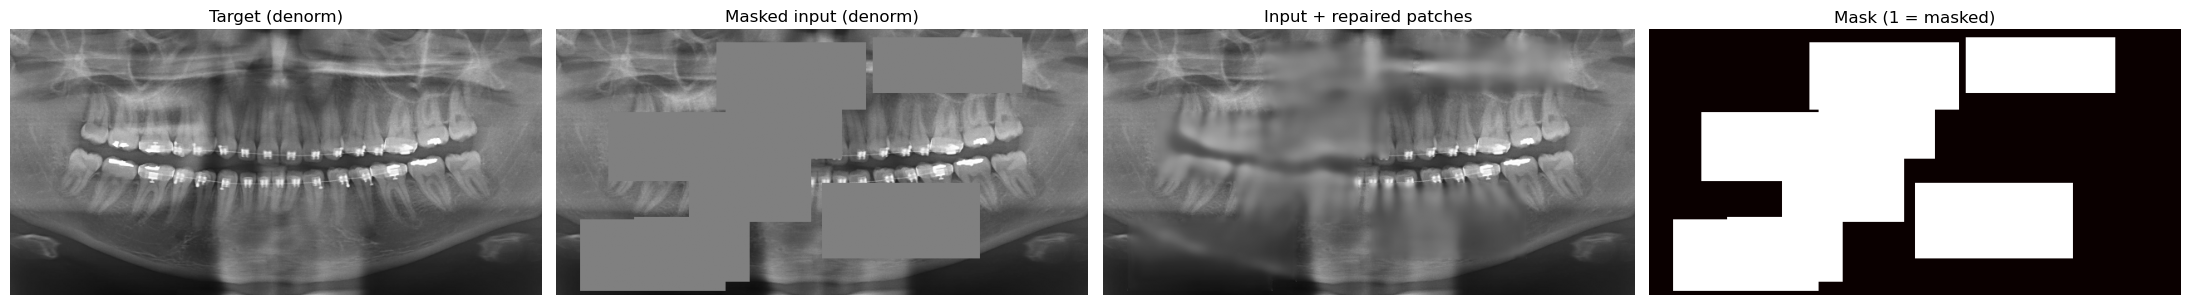

In [25]:
# Cell 12 — Improved reconstruction preview:
# show target, masked input, "input + repaired patches", pure reconstruction, and mask.

import numpy as np
import matplotlib.pyplot as plt

def denorm_np(x_np, mean=0.5, std=0.25):
    """
    De-normalize an image that was normalized with
    A.Normalize(mean=(0.5,), std=(0.25,)).
    Returns values clipped to [0, 1] for visualization.
    """
    x = x_np * std + mean
    x = np.clip(x, 0.0, 1.0)
    return x

model.eval()

NUM_PREVIEW = 3
with torch.no_grad():
    for i in range(NUM_PREVIEW):
        # dataset returns normalized tensors: (1, H, W)
        masked_img, target_img, mask_tensor, meta = pretrain_dataset[i]

        masked_img_b = masked_img.unsqueeze(0).to(device)  # (1, 1, H, W)
        pred_b = model(masked_img_b)                       # (1, 1, H, W)

        # to numpy (normalized space)
        pred_img  = pred_b.squeeze(0).squeeze(0).cpu().numpy()
        target_np = target_img.squeeze(0).cpu().numpy()
        masked_np = masked_img.squeeze(0).cpu().numpy()
        mask_np   = mask_tensor.squeeze(0).cpu().numpy()

        print(f"\n=== Reconstruction preview sample {i} ===")
        print("Image path :", meta["img_path"])
        print("age_group  :", meta["age_group"])
        print("label_status:", meta["label_status"])
        print("target_np min/max :", float(target_np.min()), float(target_np.max()))
        print("masked_np min/max :", float(masked_np.min()), float(masked_np.max()))
        print("mask_np   min/max :", float(mask_np.min()), float(mask_np.max()))
        print("pred_img  min/max :", float(pred_img.min()), float(pred_img.max()))

        # Key idea: combine input + repaired patches in normalized space:
        # X = masked input (already equal to target * (1 - mask))
        # P = pred_img (model prediction)
        # Desired inpainted result = X + P * mask
        combined_norm = masked_np + pred_img * mask_np
        combined_vis  = denorm_np(combined_norm)

        # de-normalize for nicer visualization
        target_vis = denorm_np(target_np)
        masked_vis = denorm_np(masked_np)
        pred_vis   = denorm_np(pred_img)

        fig, axes = plt.subplots(1, 4, figsize=(22, 4))

        axes[0].imshow(target_vis, cmap="gray", vmin=0, vmax=1)
        axes[0].set_title("Target (denorm)")
        axes[0].axis("off")

        axes[1].imshow(masked_vis, cmap="gray", vmin=0, vmax=1)
        axes[1].set_title("Masked input (denorm)")
        axes[1].axis("off")

        axes[2].imshow(combined_vis, cmap="gray", vmin=0, vmax=1)
        axes[2].set_title("Input + repaired patches")
        axes[2].axis("off")

        # axes[3].imshow(pred_vis, cmap="gray", vmin=0, vmax=1)
        # axes[3].set_title("Pure reconstruction (denorm)")
        # axes[3].axis("off")

        axes[3].imshow(mask_np, cmap="hot", vmin=0, vmax=1)
        axes[3].set_title("Mask (1 = masked)")
        axes[3].axis("off")

        plt.tight_layout()
        plt.show()


In [26]:
# Load existing weights
from torch.utils.data import DataLoader

from pathlib import Path
DATA_ROOT = Path("./sts_tooth_data").resolve()
print("DATA_ROOT:", DATA_ROOT)
print("len(pretrain_dataset):", len(pretrain_dataset))

PRETRAIN_BATCH_SIZE = 4
PRETRAIN_NUM_WORKERS = 0

pretrain_loader = DataLoader(
    pretrain_dataset,                      # FullImagePretrainDataset
    batch_size=PRETRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=PRETRAIN_NUM_WORKERS,
    pin_memory=(device.type == "cuda"),
)

print("pretrain_loader ready, num_batches:", len(pretrain_loader))


DATA_ROOT: E:\Data\ToothSeg\sts_tooth_data
len(pretrain_dataset): 4000
pretrain_loader ready, num_batches: 1000


In [27]:
from pathlib import Path
from tqdm.auto import tqdm

# ====== Path & Device ======
DATA_ROOT = Path("./sts_tooth_data").resolve()
CHECKPOINT_DIR = DATA_ROOT / "checkpoints"
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

ckpt_path = CHECKPOINT_DIR / "unet2d_fullimage_pretrained.pth"
print("Checkpoint path:", ckpt_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# ====== 1. Construct a U-Net with the same structure and load existing weights. ======
model = UNet2D(in_channels=1, out_channels=1, base_channels=32, bilinear=True).to(device)

state = torch.load(ckpt_path, map_location=device)

if isinstance(state, dict) and "model_state_dict" in state:
    model.load_state_dict(state["model_state_dict"])
    start_epoch = state.get("epoch", 0) + 1
    print(f"Loaded model_state_dict from checkpoint, resume from epoch ~{start_epoch}")
else:
    model.load_state_dict(state)
    start_epoch = 1
    print("Loaded plain state_dict from checkpoint, start_epoch set to 1 (for logging only)")

# ====== 2. Optimizer ======
LR = 5e-5   # If the loss doesn't decrease significantly, you can try changing it to 5e-5.
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

if isinstance(state, dict) and "optimizer_state_dict" in state:
    try:
        optimizer.load_state_dict(state["optimizer_state_dict"])
        print("Loaded optimizer_state_dict from checkpoint.")
    except Exception as e:
        print("Optimizer state in checkpoint not compatible, re-init optimizer. Error:", e)

# ====== 3. Continue training for several more epochs (with the TQDM progress bar). ======
EXTRA_EPOCHS = 30  

for epoch in range(start_epoch, start_epoch + EXTRA_EPOCHS):
    model.train()
    running_loss = 0.0
    num_batches = 0

    
    pbar = tqdm(pretrain_loader, desc=f"Epoch {epoch}", leave=False)
    for masked_img, target_img, mask_tensor, meta in pbar:
        masked_img = masked_img.to(device)   # (B, 1, H, W)
        target_img = target_img.to(device)   # (B, 1, H, W)
        mask_tensor = mask_tensor.to(device) # (B, 1, H, W)

        optimizer.zero_grad()
        pred = model(masked_img)

        
        loss = full_image_l1_loss(pred, target_img)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        num_batches += 1

        avg_batch_loss = running_loss / num_batches
        pbar.set_postfix({"loss": f"{avg_batch_loss:.6f}"})

    avg_epoch_loss = running_loss / max(1, num_batches)
    print(f"[Resume] Epoch {epoch} - avg Full train loss: {avg_epoch_loss:.6f}")

    # Save the latest weights once per epoch (overwriting the original .pth file).
    torch.save(model.state_dict(), ckpt_path)

print("Resume training done. Latest weights saved to:", ckpt_path)

Checkpoint path: E:\Data\ToothSeg\sts_tooth_data\checkpoints\unet2d_fullimage_pretrained.pth
device: cuda
Loaded plain state_dict from checkpoint, start_epoch set to 1 (for logging only)


KeyboardInterrupt: 

In [ ]:
 !tensorboard --logdir "E:\Data\ToothSeg\sts_tooth_data\runs"